## MLC HW 4

### Submission by Jon Kastelan (jlk635)



In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
np.random.seed(999)


### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

_________________________________________

In [2]:

Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


#### Data preparation

In [3]:
#Take log of traffic counts
Data1['logTrafCount'] = np.log(Data1.AvgDailyTrafficCount)

#Normalise by subtracting mean (i.e. centre about zero (0))
logTrafCountMean = Data1['logTrafCount'].mean()
Data1['logTrafCountCentered'] = Data1.logTrafCount - logTrafCountMean

Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logTrafCount,logTrafCountCentered
0,-80.278366,40.468606,84.0,4.430817,-3.977526
1,-80.162117,40.384598,95.0,4.553877,-3.854466
2,-80.221205,40.366778,97.0,4.574711,-3.833632
3,-80.142455,40.622084,111.0,4.709530,-3.698812
4,-80.131975,40.544915,125.0,4.828314,-3.580029


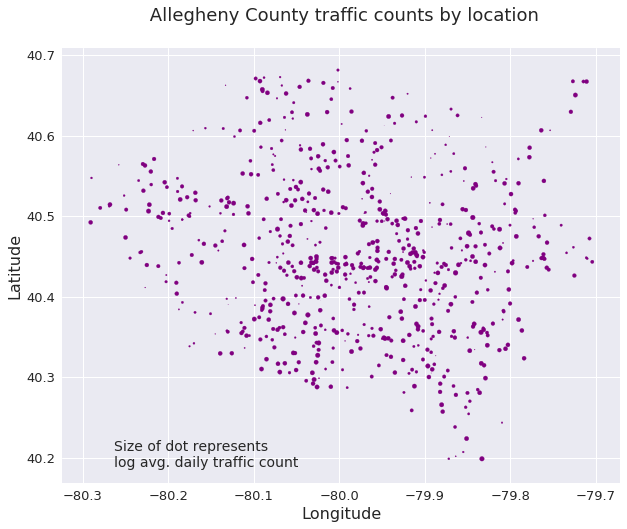

In [4]:
fig = plt.figure(figsize=(10,8))
labe = 'Size of dot represents\nlog avg. daily traffic count'
plt.scatter(Data1.Longitude, Data1.Latitude, s=Data1.logTrafCountCentered*20, c='purple', label=labe);
plt.title(' Allegheny County traffic counts by location\n', fontsize = 18)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(markerscale=100, fontsize = 14);

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)



In [5]:
X = np.array(Data1[['Longitude', 'Latitude']])  # we only take the first two features.
y = np.array(Data1.logTrafCountCentered, dtype=float)
X[0:5], y[0:5]

(array([[-80.27836587,  40.46860562],
        [-80.16211738,  40.38459789],
        [-80.22120473,  40.36677795],
        [-80.14245484,  40.6220841 ],
        [-80.13197496,  40.54491527]]),
 array([-3.97752579, -3.85446569, -3.83363161, -3.69881238, -3.58002885]))

In [6]:
# Instantiate a Gaussian Process model with a radial basis function kernel.

#kernel = RBF(length_scale, (length_scale_range_min, length_scale_range_max)) # parameters of RBF kernel: length_scale, (length_scale_range_min, length_scale_range_max)
k1 = 1.0 * RBF([0.1])
k2 = 1.**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e3))  # noise terms

kernel = k1 + k2
gp = GaussianProcessRegressor(kernel=kernel, random_state=999)

X = np.array(Data1[['Longitude', 'Latitude']])  # we only take the first two features.
y = np.array(Data1.logTrafCountCentered, dtype=float)

# Fit to data using maximum likelihood estimation of the parameters
gpc_rbf = gp.fit(X, y)
print(gpc_rbf)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=0.1) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=999)


2) The log marginal likelihood of the training data. (5 pts)



In [7]:
print(gp.log_marginal_likelihood_value_)

-1365.02775338


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)


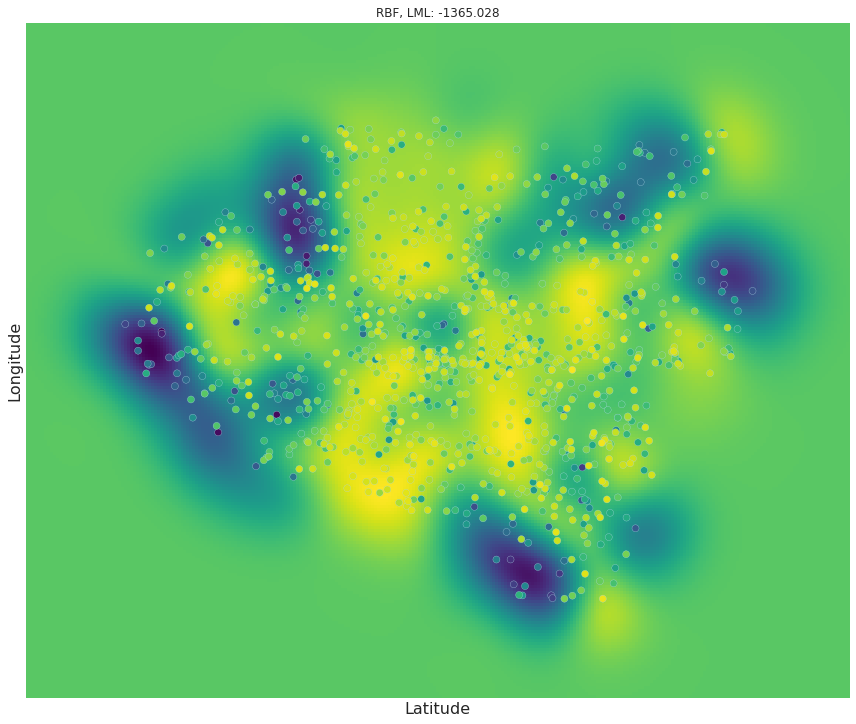

In [8]:
h = .003  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(12, 12))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
## Assign a color to each of the actual sensor observations (based on location)
A = gpc_rbf.predict(X)
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))#, 3))
#A = A.reshape(X.shape[0], X.shape[1])
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap='viridis', origin="lower")

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1],  c=y, cmap='viridis', edgecolors='lightblue')
plt.xlabel('Latitude', fontsize = 16)
plt.ylabel('Longitude', fontsize = 16)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gpc_rbf.log_marginal_likelihood(gpc_rbf.kernel_.theta)))



plt.tight_layout()
plt.show()


4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)


In [9]:
threshold = 2

PredWithVar = gpc_rbf.predict(X, return_std=True) # returns two arrays, one with the estimate; the other with std_dev
TestStatCalc = abs(y - PredWithVar[0])/PredWithVar[1]
absTestStat = abs(TestStatCalc)

anomalies = sum(absTestStat > threshold)
totalSensors = len(absTestStat)

print("The total number of sensors with traffic counts more than two (2) standard deviations \n" +
      "higher or lower than the model predicts is {0}, which is {1}% of all sensors "
      .format(anomalies,round(float(anomalies)/totalSensors*100,2)))

The total number of sensors with traffic counts more than two (2) standard deviations 
higher or lower than the model predicts is 49, which is 4.39% of all sensors 


In [10]:
TestStatCalc = (y - PredWithVar[0])/PredWithVar[1]
(TestStatCalc>2).sum()

4

In [11]:
X.shape

(1115, 2)


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [12]:
cluster = 0 * TestStatCalc  #all point assigned to cluster 0 by default
cluster = cluster + ((y - PredWithVar[0])/PredWithVar[1] < -1 * threshold)*1 #assign clusters less than 2 std dev's away from mean to cluster 1
cluster = cluster + ((y - PredWithVar[0])/PredWithVar[1] >  threshold)*2 #assign clusters greater than 2 std dev's away from mean to cluster 2
cluster

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

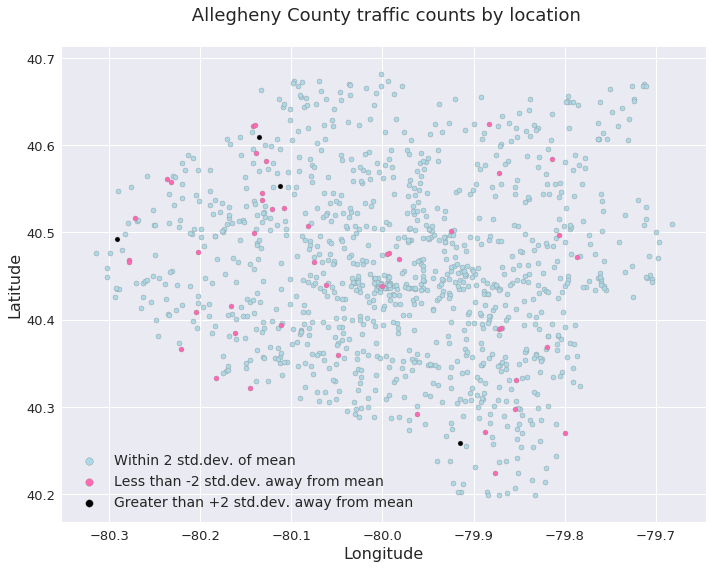

In [13]:
fig = plt.figure(figsize=(10,8))
labe = ["Within 2 std.dev. of mean", "Less than -2 std.dev. away from mean", "Greater than +2 std.dev. away from mean"]

colorArray = np.array(["lightblue", "hotpink", "black"])

for i, col in enumerate(colorArray):
    plt.scatter(Data1.Longitude[cluster==i], Data1.Latitude[cluster==i], s=25, c=col, edgecolors='grey', label=labe[i]);

plt.title(' Allegheny County traffic counts by location\n', fontsize = 18)
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(markerscale=1.5, fontsize = 14, loc='lower left');


plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here

(1, 0)		**Anomaly** - the closest cluster center is (0,0) but those 100 points are tightly concentrated (with std. dev. = 0.1). This point (1, 0) is a large number of standard deviations (greater than 5) away from the centre.


(35, 2)		**Not Anomaly** - closest cluster center is (35,5) and point is within a reasonable std. dev. distance of the cluster (the standard deviation is 5, so we're less than a single standard deviation away from the center).


(15, 19)	**Anomaly** - it's a member of the cluster with center (15, 20). This has only two points, so both these observations would be considered anomalies. 


(10, 11)	**Not Anomaly** - closest cluster center is (10, 10). The standard deviation of cluster is 1; and the point (10, 11) is within 1 standard deviation away form the center.


### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [14]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [15]:
Data2 = Data2.copy()

In [16]:
#Convert to numeric
Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

#Drop Nan values
Data2.dropna(inplace=True)

#Reset index
Data2.reset_index(drop=True, inplace=True)



In [17]:
# your code here
Data2.columns

Index([u'County', u''\% Reporting Fair/Poor Health'',
       u''Physically Unhealthy Days Per Month'',
       u''Mentally Unhealthy Days Per Month'', u''\% Low birth weight births'',
       u''\% Smokers'', u''\% Obese'', u''Food Environment Index'',
       u''\% Physically Inactive'', u''\% With Access To Exercise'',
       u''\% Excessive Drinking'', u''\% Alcohol-Impaired Driving Deaths'',
       u''Chlamydia Rate'', u''Teen Birth Rate'', u''\% Uninsured'',
       u''Preventable Hosp. Rate'', u''\% Dibetics receiving HbA1c'',
       u''\% Mammography'', u''Graduation Rate'', u''\% Some College'',
       u''\% Unemployed'', u''\% Children in Poverty'',
       u''80/20 Income Ratio'', u''\% Single-Parent Households'',
       u''Association Rate'', u''Violent Crime Rate'', u''Injury Death Rate'',
       u''Average Daily PM2.5'', u''\% Severe Housing Problems'',
       u''\% Drive Alone'', u''\% Long Commute - Drives Alone''],
      dtype='object')

### Part 1: 

Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 


In [18]:
Data2Subset = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'",
                     "'\% Children in Poverty'","'Average Daily PM2.5'"]]



In [19]:
#Rename columns headings
renameColumns = {"'\% Smokers'":'pctSmokers',
                 "'\% Obese'":'pctObese',
                 "'Violent Crime Rate'":'ViolentCrimeRate',
                 "'80/20 Income Ratio'":'IncomeRatio',
                 "'\% Children in Poverty'": 'pctChildrenInPoverty',
                 "'Average Daily PM2.5'":'AvgDailyPM2.5'}
                 
Data2Subset.rename(columns = renameColumns, inplace = True)
Data2Subset.dropna(inplace = True)

/nfshome/jlk635/.conda/envs/VirtEnv/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/nfshome/jlk635/.conda/envs/VirtEnv/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [20]:
Data2SubsetDiscr = Data2Subset.copy()
Data2SubsetDiscr.head()

,pctSmokers,pctObese,ViolentCrimeRate,IncomeRatio,pctChildrenInPoverty,AvgDailyPM2.5
0,19.0,31,254.0,4.3,18.0,12.9
1,19.0,27,221.0,4.5,20.0,13.1
2,21.0,41,147.0,5.3,38.0,12.6
3,21.0,40,236.0,4.3,27.0,12.9
4,19.0,32,219.0,4.1,24.0,12.7


In [21]:

for i in Data2Subset.columns: 
    Data2SubsetDiscr[i] = pd.cut(Data2Subset[i], 5, labels=[0,1,2,3,4])
    Data2SubsetDiscr[i] = Data2SubsetDiscr[i].apply(pd.to_numeric, errors='coerce')

#Data2SubsetDiscr.dropna(inplace=True)

In [22]:
Data2SubsetDiscr.dtypes

pctSmokers              category
pctObese                category
ViolentCrimeRate        category
IncomeRatio             category
pctChildrenInPoverty    category
AvgDailyPM2.5           category
dtype: object

In [23]:
Data2SubsetDiscr.head()

,pctSmokers,pctObese,ViolentCrimeRate,IncomeRatio,pctChildrenInPoverty,AvgDailyPM2.5
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,2,3


In [24]:
for i in Data2SubsetDiscr.columns:
    print(Data2SubsetDiscr[i].unique())

[1, 2, 3, 0, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
[2, 4, 3, 1, 0]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
[0, 1, 2, 4, 3]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
[1, 2, 3, 0, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
[1, 3, 2, 4, 0]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
[3, 1, 2, 0, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]


In [25]:
hc = HillClimbSearch(Data2SubsetDiscr, scoring_method=BicScore(Data2SubsetDiscr))
best_model = hc.estimate()
print(best_model.edges())

[('ViolentCrimeRate', 'pctChildrenInPoverty'), ('pctChildrenInPoverty', 'IncomeRatio'), ('pctChildrenInPoverty', 'pctSmokers'), ('pctSmokers', 'AvgDailyPM2.5'), ('pctSmokers', 'pctObese')]


In [26]:
model = BayesianModel(best_model.edges())
model.fit(Data2SubsetDiscr, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of AvgDailyPM2.5:
+------------------+-----------------+-----------------+------------------+---------------+---------------+
| pctSmokers       | pctSmokers(0)   | pctSmokers(1)   | pctSmokers(2)    | pctSmokers(3) | pctSmokers(4) |
+------------------+-----------------+-----------------+------------------+---------------+---------------+
| AvgDailyPM2.5(0) | 0.207692307692  | 0.0532043530834 | 0.00888888888889 | 0.0           | 0.0           |
+------------------+-----------------+-----------------+------------------+---------------+---------------+
| AvgDailyPM2.5(1) | 0.169230769231  | 0.168681983071  | 0.0948148148148  | 0.0           | 0.5           |
+------------------+-----------------+-----------------+------------------+---------------+---------------+
| AvgDailyPM2.5(2) | 0.292307692308  | 0.286577992745  | 0.198518518519   | 0.16          | 0.5           |
+------------------+-----------------+-----------------+------------------+---------------+---------------+
| AvgD

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [27]:
Data2SubsetDiscr = Data2SubsetDiscr.apply(pd.to_numeric, errors='coerce')

Data2SubsetDiscr.dropna(inplace=True)

In [28]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [29]:
Data2SubsetDiscr.dtypes

pctSmokers              int64
pctObese                int64
ViolentCrimeRate        int64
IncomeRatio             int64
pctChildrenInPoverty    int64
AvgDailyPM2.5           int64
dtype: object

In [30]:

# compute anomalousness of each of the first 500 data records


exmp = Data2SubsetDiscr.apply(lambda x: LL(x,model),axis=1)

In [31]:
# 5 most anomalous counties
exmp2=pd.Series(exmp)
Top5 = exmp2.sort_values().head(5)
print exmp2.sort_values().head(5)


1444   -16.608495
182    -14.827149
1577   -14.686742
1007   -14.457849
248    -13.671439
dtype: float64


In [32]:
Top5.index

Int64Index([1444, 182, 1577, 1007, 248], dtype='int64')

In [33]:
print("The five most anomalous counties are:")
for i in Top5.index:
    print Data2[u'County'][i]

The five most anomalous counties are:
New York, New York
San Francisco, California
Rolette, North Dakota
Suffolk, Massachusetts
District of Columbia, District of Columbia


### Part 2: 
Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [34]:
fullData = Data2.copy()

In [35]:
fullData.columns

Index([u'County', u''\% Reporting Fair/Poor Health'',
       u''Physically Unhealthy Days Per Month'',
       u''Mentally Unhealthy Days Per Month'', u''\% Low birth weight births'',
       u''\% Smokers'', u''\% Obese'', u''Food Environment Index'',
       u''\% Physically Inactive'', u''\% With Access To Exercise'',
       u''\% Excessive Drinking'', u''\% Alcohol-Impaired Driving Deaths'',
       u''Chlamydia Rate'', u''Teen Birth Rate'', u''\% Uninsured'',
       u''Preventable Hosp. Rate'', u''\% Dibetics receiving HbA1c'',
       u''\% Mammography'', u''Graduation Rate'', u''\% Some College'',
       u''\% Unemployed'', u''\% Children in Poverty'',
       u''80/20 Income Ratio'', u''\% Single-Parent Households'',
       u''Association Rate'', u''Violent Crime Rate'', u''Injury Death Rate'',
       u''Average Daily PM2.5'', u''\% Severe Housing Problems'',
       u''\% Drive Alone'', u''\% Long Commute - Drives Alone''],
      dtype='object')

In [36]:
#Rename columns headings
renameColumns = {"'\% Reporting Fair/Poor Health'":'FairPoorHealth',
                 "'Physically Unhealthy Days Per Month'":'physicallyUnhealthDaysPmonth',
                 "'Mentally Unhealthy Days Per Month'":'mentallyUnhealthyDaysPmonth', 
                 "'\% Low birth weight births'":'pctLowBirthWeights',
                 "'\% Smokers'":'pctSmokers', 
                 "'\% Obese'":'pctObese', 
                 "'Food Environment Index'":'foodEnvionmentIndex',
                 "'\% Physically Inactive'":'pctPhysicallyInactive', 
                 "'\% With Access To Exercise'":'pctAccessExercise',
                 "'\% Excessive Drinking'":'pctExcessDrinking', 
                 "'\% Alcohol-Impaired Driving Deaths'":'pctAlcoholDrivingDeaths',
                 "'Chlamydia Rate'":'chlamydiaRate', 
                 "'Teen Birth Rate'":'teenBirthRate', 
                 "'\% Uninsured'":'pctUninsured',
                 "'Preventable Hosp. Rate'":'preventHospRate', 
                 "'\% Dibetics receiving HbA1c'":'pctDiabeticsRecTreat',
                 "'\% Mammography'":'pctMammography', 
                 "'Graduation Rate'":'pctGraduationRate', 
                 "'\% Some College'":'pctSomeCollege',
                 "'\% Unemployed'":'pctUnemployed', 
                 "'\% Children in Poverty'": 'pctChildrenInPoverty',
                 "'80/20 Income Ratio'":'IncomeRatio',
                 "'\% Single-Parent Households'":'pctSingleParentHH',
                 "'Association Rate'":'AssociationRate', 
                 "'Violent Crime Rate'":'ViolentCrimeRate',
                 "'Injury Death Rate'":'injuryDeathRate',
                 "'Average Daily PM2.5'":'AvgDailyPM2.5',
                 "'\% Severe Housing Problems'":'pctSeverHousingProbs',
                 "'\% Drive Alone'":'pctDriveAlone', 
                 "'\% Long Commute - Drives Alone'":'pctLongCommute'
                 }

In [37]:
fullData.rename(columns = renameColumns, inplace = True)

In [38]:
fullData.head()

,County,FairPoorHealth,physicallyUnhealthDaysPmonth,mentallyUnhealthyDaysPmonth,pctLowBirthWeights,pctSmokers,pctObese,foodEnvionmentIndex,pctPhysicallyInactive,pctAccessExercise,...,pctChildrenInPoverty,IncomeRatio,pctSingleParentHH,AssociationRate,ViolentCrimeRate,injuryDeathRate,AvgDailyPM2.5,pctSeverHousingProbs,pctDriveAlone,pctLongCommute
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31,7.1,29,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27,7.6,25,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41,5.1,33,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40,7.4,33,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32,8.3,29,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12,85.0,59.0


In [39]:
fullData.columns

Index([u'County', u'FairPoorHealth', u'physicallyUnhealthDaysPmonth',
       u'mentallyUnhealthyDaysPmonth', u'pctLowBirthWeights', u'pctSmokers',
       u'pctObese', u'foodEnvionmentIndex', u'pctPhysicallyInactive',
       u'pctAccessExercise', u'pctExcessDrinking', u'pctAlcoholDrivingDeaths',
       u'chlamydiaRate', u'teenBirthRate', u'pctUninsured', u'preventHospRate',
       u'pctDiabeticsRecTreat', u'pctMammography', u'pctGraduationRate',
       u'pctSomeCollege', u'pctUnemployed', u'pctChildrenInPoverty',
       u'IncomeRatio', u'pctSingleParentHH', u'AssociationRate',
       u'ViolentCrimeRate', u'injuryDeathRate', u'AvgDailyPM2.5',
       u'pctSeverHousingProbs', u'pctDriveAlone', u'pctLongCommute'],
      dtype='object')

In [40]:
X = fullData.iloc[:,1:]


(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)


In [41]:

KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [42]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
1890,2443.716031,1970.018443,2251.260167,1,1970.018443
1294,2036.147297,1332.735955,1759.249198,1,1332.735955
96,1917.732820,1208.900834,1639.063836,1,1208.900834
2304,1644.876605,1017.910163,1394.632068,1,1017.910163
995,1651.954082,918.374430,1366.737248,1,918.374430


In [43]:
# check for tiny clusters
print res['cluster'].value_counts()

0    1426
2     814
1     246
Name: cluster, dtype: int64


In [44]:
furthest5_KM = res.sort_values("score",ascending=False)[:5]

In [45]:
print("The furthest five counties (to a cluster center with K-means) are:")
for i in furthest5_KM.index:
    print Data2[u'County'][i]

The furthest five counties (to a cluster center with K-means) are:
Shannon, South Dakota
St. Louis City, Missouri
Crittenden, Arkansas
Petersburg City, Virginia
Baltimore City, Maryland



(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)


In [46]:
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [47]:
furthest5_GM = pd.Series(GM.score_samples(X)).sort_values().head()

In [48]:
print("The furthest five counties (based on log-likelihood with Gaussian Mixture) are:")
for i in furthest5_GM.index:
    print Data2[u'County'][i]

The furthest five counties (based on log-likelihood with Gaussian Mixture) are:
Shannon, South Dakota
Apache, Arizona
New York, New York
Willacy, Texas
Rolette, North Dakota




Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)


**Use Local Outlier Factor**

In [49]:
# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=20,
          p=2)

In [50]:
furthest5_LOF = pd.Series(clf.negative_outlier_factor_).sort_values().head()

In [51]:
furthest5_LOF

1890   -4.855389
1294   -2.600860
96     -2.378684
2378   -2.170029
2304   -2.145245
dtype: float64

In [52]:
print("The furthest five counties (based on negative outlier factor with Local Outlier Factor) are:")
for i in furthest5_LOF.index:
    print Data2[u'County'][i]

The furthest five counties (based on negative outlier factor with Local Outlier Factor) are:
Shannon, South Dakota
St. Louis City, Missouri
Crittenden, Arkansas
Nicholas, West Virginia
Petersburg City, Virginia




Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

______________________________

For each of K-means, Gaussian Mixture and Local outlier factor models; Shannon, South Dakota is found the be the most anomalous county. The results for K-means and Local Outlier Factor are very similar; both returning St. Louis City, Missouri; Crittenden, Arkansas and Petersburg City, Virginia also. The counties they differ on are Baltimore City, Maryland (K-means) and Nicholas, West Virginia (Local outlier factor).

The Gaussian Mixture clustering model provided four (4) different counties to the other two methods Apache, Arizona; New York, New York; Willacy, Texas and Rolette, North Dakota.

Let's inspect which variables are likely to have the highest influence in the clustering model by descriving the dataset.

In [53]:
fullData.loc[:,:'pctExcessDrinking'].describe()

,FairPoorHealth,physicallyUnhealthDaysPmonth,mentallyUnhealthyDaysPmonth,pctLowBirthWeights,pctSmokers,pctObese,foodEnvionmentIndex,pctPhysicallyInactive,pctAccessExercise,pctExcessDrinking
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,17.203942,3.865809,3.753097,8.222446,18.569992,31.022928,7.093242,27.162108,63.002011,16.604988
std,4.856641,0.715394,0.581101,1.971016,3.646631,4.524278,1.069392,5.554257,22.020285,3.420385
min,7.000000,2.200000,2.100000,3.000000,7.000000,11.000000,0.500000,9.000000,0.000000,9.000000
25%,13.000000,3.400000,3.300000,7.000000,16.000000,29.000000,6.500000,24.000000,48.000000,14.000000
50%,16.000000,3.800000,3.800000,8.000000,18.000000,31.000000,7.200000,27.000000,65.000000,17.000000
75%,20.000000,4.400000,4.100000,9.000000,21.000000,34.000000,7.800000,31.000000,80.000000,19.000000
max,42.000000,6.500000,5.600000,19.000000,41.000000,46.000000,10.000000,42.000000,100.000000,27.000000


In [54]:
fullData.loc[:,'pctExcessDrinking':'pctSomeCollege'].describe()

,pctExcessDrinking,pctAlcoholDrivingDeaths,chlamydiaRate,teenBirthRate,pctUninsured,preventHospRate,pctDiabeticsRecTreat,pctMammography,pctGraduationRate,pctSomeCollege
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,16.604988,30.886163,353.059533,41.796862,16.988335,62.772727,84.739743,60.789220,84.398230,56.113033
std,3.420385,12.739343,217.303794,18.499012,5.185286,24.107878,5.918107,7.798972,8.568666,11.311936
min,9.000000,0.000000,35.000000,4.000000,3.000000,12.000000,19.000000,26.000000,3.000000,20.200000
25%,14.000000,23.000000,208.000000,28.000000,13.000000,48.000000,83.000000,56.000000,80.000000,48.100000
50%,17.000000,30.000000,296.500000,40.000000,17.000000,59.000000,86.000000,61.000000,86.000000,56.000000
75%,19.000000,38.000000,439.000000,53.000000,20.000000,73.000000,88.000000,66.000000,91.000000,64.000000
max,27.000000,100.000000,2653.000000,124.000000,38.000000,231.000000,96.000000,84.000000,100.000000,88.300000


In [55]:
fullData.loc[:,'pctSomeCollege':].describe()

,pctSomeCollege,pctUnemployed,pctChildrenInPoverty,IncomeRatio,pctSingleParentHH,AssociationRate,ViolentCrimeRate,injuryDeathRate,AvgDailyPM2.5,pctSeverHousingProbs,pctDriveAlone,pctLongCommute
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,56.113033,6.451247,23.844730,4.545133,33.345937,12.731175,267.538616,74.454545,11.720072,14.958568,80.197908,30.881738
std,11.311936,2.067366,8.692791,0.695486,9.383930,4.981697,198.532609,21.554035,1.535203,4.277249,5.945515,11.935865
min,20.200000,1.200000,3.000000,2.700000,1.000000,1.000000,0.000000,25.000000,7.200000,5.000000,6.000000,3.000000
25%,48.100000,5.100000,17.250000,4.100000,27.000000,9.300000,128.000000,60.000000,10.600000,12.000000,78.000000,22.000000
50%,56.000000,6.200000,23.000000,4.400000,33.000000,12.100000,216.000000,72.000000,12.000000,14.000000,81.000000,30.000000
75%,64.000000,7.600000,29.000000,4.900000,38.000000,15.500000,356.750000,87.000000,13.000000,17.000000,84.000000,39.000000
max,88.300000,23.600000,54.000000,8.700000,76.000000,41.000000,1885.000000,200.000000,14.900000,44.000000,95.000000,72.000000


The features with highest variability are Chlamydia Rate, Violent Crime rate, % access exercise and Injury death rate. These are likely the factors which our chose counties exhibit more extreme values in relative to the other counties making them anomalies.

The K-means and Local outlier factor models use similar estimates of distance (Euclidean and Minkowski); so the provide similar results. Whereas the Gaussian Mixture uses log-likelihood as its scoring approach; hence returns different counties.

#### END